In [1]:
from numba import njit

@njit
def add_samples_to_map(tod, pixel_indexes, accum_map, hit_count_map):
    ndet, nsample = tod.shape

    for det_idx in range(ndet):
        for sample_idx in range(nsample):
            pix_idx = pixel_indexes[sample_idx]
            accum_map[pix_idx] += tod[det_idx, sample_idx]
            hit_count_map[pix_idx] += 1

@njit
def normalize_map(accum_map, hit_count_map):
    ndet, nsample = tod.shape

    for pix_idx in range(len(accum_map)):
        if hit_count_map[pix_idx] > 0:
            accum_map[pix_idx] /= hit_count_map[pix_idx]

Number of observations: 360


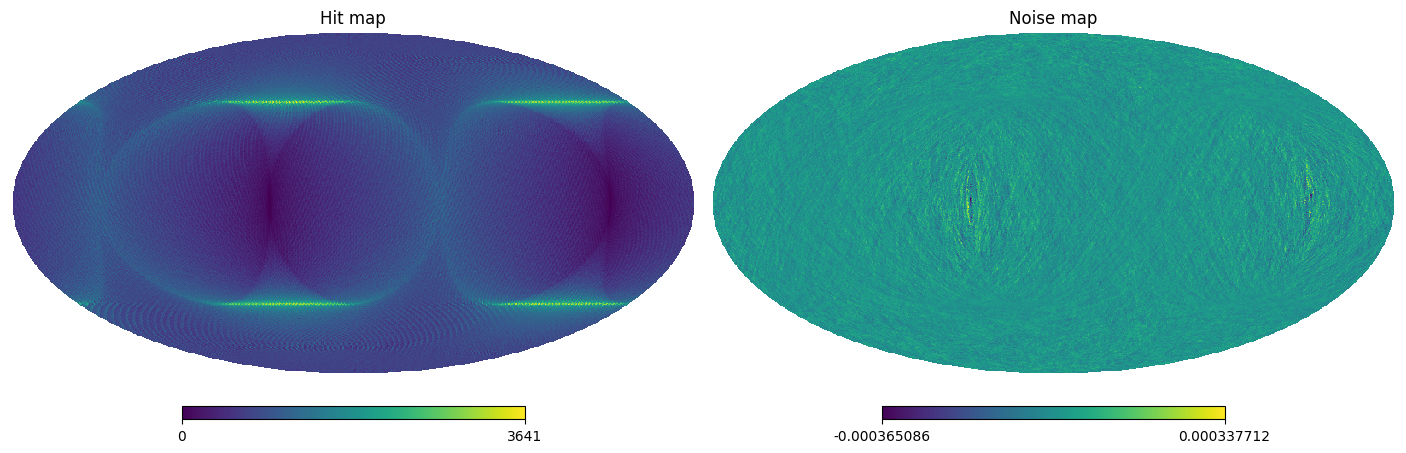

CPU times: user 3min 13s, sys: 5.55 s, total: 3min 18s
Wall time: 1min 31s


In [5]:
%%time

import sys, os
sys.path.append(os.path.abspath("../mylib_project"))

from mylib import add_OofaNoise

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from uuid import UUID
from numba import njit
import litebird_sim as lbs



# SIMULATION

nside = 2**7 # map resolution (tipico di liteBIRD)
start_time = 0
chunk_length = 3600 * 6
number_of_days = 90
duration_s = 86400 * number_of_days 
num_of_observations = duration_s // chunk_length

sim = lbs.Simulation(
    start_time=start_time,
    duration_s=duration_s,
    random_seed=12345,
    imo=lbs.Imo(flatfile_location=lbs.PTEP_IMO_LOCATION)
)



# SCANNING STRATEGY (from IMO)

sim.set_scanning_strategy(
    lbs.SpinningScanningStrategy.from_imo(imo=lbs.Imo(lbs.PTEP_IMO_LOCATION), url=UUID("117fd641-a925-4eeb-9fda-f7c468682108")),
    delta_time_s=120.0
)



# INSTRUMENT & DETECTOR

instrument = lbs.InstrumentInfo(
    boresight_rotangle_rad=0.0,
    spin_boresight_angle_rad=np.deg2rad(90),
    spin_rotangle_rad=np.deg2rad(75)
)
sim.set_instrument(instrument)

det = lbs.DetectorInfo(
    name="Boresight_detector",
    sampling_rate_hz=20.0, 
    bandcenter_ghz=100.0,
    net_ukrts=50.0,
    fknee_mhz=500.0,
    fmin_hz=1e-5,
    alpha=1
)



# OBSERVATION

sim.create_observations(detectors=det, num_of_obs_per_detector=num_of_observations, allocate_tod=False)

tod = np.empty((1, int(det.sampling_rate_hz * chunk_length)))
accum_map = np.zeros(hp.nside2npix(nside))
hit_count_map = np.zeros(len(accum_map), dtype='int64')


img_dir = "img"
os.makedirs(img_dir, exist_ok=True)


for obs_idx, cur_obs in enumerate(sim.observations):
    
    # POINTINGS
    lbs.prepare_pointings(cur_obs, instrument, sim.spin2ecliptic_quats)
    pointings, _ = cur_obs.get_pointings("all")
    #print(f"Observation {obs_idx + 1} of {len(sim.observations)}, number of pointings: {pointings.shape}")

    theta = pointings[0, :, 0]
    phi   = pointings[0, :, 1]
    pixidx = hp.ang2pix(nside, theta, phi)
    
    # NOISE
    tod[:, :] = 0.0
    add_OofaNoise(tod, det, block_duration_s=chunk_length)
    add_samples_to_map(tod, pixidx, accum_map, hit_count_map)    

    # ANIMATION MAP
    onoff_map = hit_count_map > 0

    hp.mollview(onoff_map.astype(int), title=f"LiteBIRD scanning – observation {obs_idx + 1}")
    
    filename = os.path.join(img_dir, f"{obs_idx:04d}.png")
    plt.savefig(filename, dpi=150)
    plt.close()


normalize_map(accum_map, hit_count_map)

print(f"Number of observations: {num_of_observations}")

# PLOT HEALPIX MAP

plt.figure(figsize=(14, 6))

hp.mollview(hit_count_map, title="Hit map", sub=(1,2,1))

hp.mollview(accum_map, title="Noise map", sub=(1,2,2))

plt.savefig("hp.pdf")
plt.show()